In [1]:
# Cell 1: Imports
import requests
from sgp4.api import Satrec
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd

In [8]:
# Cell 2: Fetch TLE Data from Celestrak
# Function to fetch TLEs for a specific set (e.g., 'stations' for ISS)
def fetch_tles(set_name='stations'):
    url = f"https://celestrak.org/NORAD/elements/{set_name}.txt"
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Failed to fetch TLE from {url}")
    lines = response.text.splitlines()
    
    tles = []
    i = 0
    while i < len(lines) - 2:
        name = lines[i].strip()
        line1 = lines[i+1].strip()
        line2 = lines[i+2].strip()
        if line1.startswith('1 ') and line2.startswith('2 '):
            tles.append({'name': name, 'line1': line1, 'line2': line2})
            i += 3
        else:
            i += 1
    return tles

# Example: Fetch TLEs for ISS (stations set)
tles = fetch_tles('stations')
print(f"Fetched {len(tles)} satellites. Example: {tles[0]}")

Fetched 13 satellites. Example: {'name': 'ISS (ZARYA)', 'line1': '1 25544U 98067A   25248.13333647  .00010878  00000+0  19750-3 0  9999', 'line2': '2 25544  51.6332 270.8228 0004213 301.3502  58.7074 15.50112942527561'}


In [ ]:
# Cell 3: Propagate Positions Using SGP4 (Fixed)
def generate_positions(tle, start_time, duration_minutes=60, step_seconds=60):
    satellite = Satrec.twoline2rv(tle['line1'], tle['line2'])
    
    positions = []
    for minute in range(0, duration_minutes, step_seconds // 60):
        t = start_time + timedelta(minutes=minute)
        # Ensure timezone-aware datetime for subtraction
        t_base = datetime(t.year, t.month, t.day, tzinfo=timezone.utc)
        # Calculate Julian Day (jd) and fraction (fr)
        jd = t.toordinal() + (t - t_base).total_seconds() / 86400.0
        fr = jd % 1
        jd = int(jd)
        
        e, r, v = satellite.sgp4(jd, fr)  # r = position in km (ECI), v = velocity in km/s
        if e == 0:  # No error
            positions.append({
                'name': tle['name'],
                'time': t.isoformat(),
                'x_km': r[0],
                'y_km': r[1],
                'z_km': r[2],
                'vx_kms': v[0],
                'vy_kms': v[1],
                'vz_kms': v[2]
            })
    
    return pd.DataFrame(positions)

# Example: Propagate for first satellite (e.g., ISS)
start_time = datetime.now(timezone.utc)  # Use current UTC time
df_positions = generate_positions(tles[0], start_time, duration_minutes=60, step_seconds=60)
print(df_positions.head())


          name                              time          x_km          y_km  \
0  ISS (ZARYA)  2025-09-05T19:01:10.555083+00:00 -1.950522e+22  2.777276e+23   
1  ISS (ZARYA)  2025-09-05T19:02:10.555083+00:00  2.560096e+23  8.390148e+22   
2  ISS (ZARYA)  2025-09-05T19:03:10.555083+00:00 -7.381471e+21  2.836223e+23   
3  ISS (ZARYA)  2025-09-05T19:04:10.555083+00:00 -2.344518e+23  4.974669e+21   
4  ISS (ZARYA)  2025-09-05T19:05:10.555083+00:00 -1.218108e+23  2.144587e+23   

           z_km        vx_kms        vy_kms        vz_kms  
0  3.237532e+23 -6.795977e-10 -3.013489e-10  5.068222e-11  
1 -5.359321e+22  4.385840e-10  9.039457e-10  7.622351e-10  
2  3.223535e+23 -6.790007e-10 -2.765302e-10  8.467461e-11  
3  1.427948e+23  3.241360e-11 -8.307985e-10 -9.489701e-10  
4  3.113981e+23 -6.113233e-10 -5.214422e-10 -2.224572e-10  


In [13]:
# Cell 4: Batch Process Multiple Satellites
def batch_generate_positions(tles, start_time, duration_minutes=60, step_seconds=60, max_sats=5):
    dfs = []
    for tle in tles[:max_sats]:  # Limit for testing
        df_sat = generate_positions(tle, start_time, duration_minutes, step_seconds)
        dfs.append(df_sat)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Run batch
df_all = batch_generate_positions(tles, start_time, duration_minutes=60, step_seconds=60)
print(f"Generated positions for {len(df_all['name'].unique())} satellites.")
print(df_all.head())

Generated positions for 2 satellites.
          name                              time          x_km          y_km  \
0  ISS (ZARYA)  2025-09-05T19:01:10.555083+00:00 -1.950522e+22  2.777276e+23   
1  ISS (ZARYA)  2025-09-05T19:02:10.555083+00:00  2.560096e+23  8.390148e+22   
2  ISS (ZARYA)  2025-09-05T19:03:10.555083+00:00 -7.381471e+21  2.836223e+23   
3  ISS (ZARYA)  2025-09-05T19:04:10.555083+00:00 -2.344518e+23  4.974669e+21   
4  ISS (ZARYA)  2025-09-05T19:05:10.555083+00:00 -1.218108e+23  2.144587e+23   

           z_km        vx_kms        vy_kms        vz_kms  
0  3.237532e+23 -6.795977e-10 -3.013489e-10  5.068222e-11  
1 -5.359321e+22  4.385840e-10  9.039457e-10  7.622351e-10  
2  3.223535e+23 -6.790007e-10 -2.765302e-10  8.467461e-11  
3  1.427948e+23  3.241360e-11 -8.307985e-10 -9.489701e-10  
4  3.113981e+23 -6.113233e-10 -5.214422e-10 -2.224572e-10  


In [14]:
# Cell 5: Save Output
output_path = '../data/processed/satellite_positions'
df_all.to_csv(f"{output_path}.csv", index=False)
df_all.to_json(f"{output_path}.json", orient='records')
print(f"Saved to {output_path}.csv and .json")

Saved to ../data/processed/satellite_positions.csv and .json


NameError: name 'df_all' is not defined

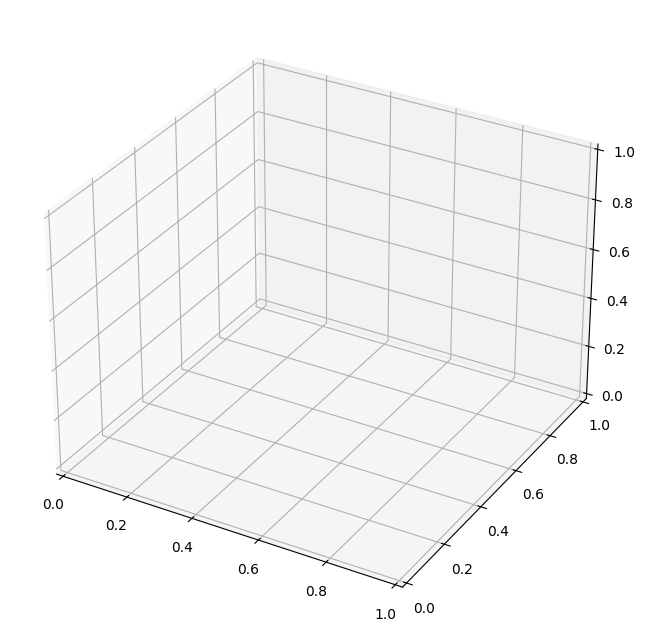

In [ ]:
# Cell 6: Visualize Orbits in 3D
if not df_all.empty:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for name in df_all['name'].unique():
        df_sat = df_all[df_all['name'] == name]
        ax.plot(df_sat['x_km'], df_sat['y_km'], df_sat['z_km'], label=name)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.legend()
    plt.show()
else:
    print("No data to visualize. Ensure earlier cells ran successfully.")